In [1]:
import os
import glob
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import hist
from hist import Hist
import os, sys
import re
import pickle
import vector
import mplhep as hep
import math
from tabulate import tabulate
from collections import defaultdict

vector.register_awkward()

# parameters for matplotlib styling
plt.style.use(hep.style.CMS)

matplotlib.rcParams.update({'figure.max_open_warning': 0})
matplotlib.rcParams.update({'font.size': 20})
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
# parameters
unblind = False                               # don't show D_obs for SUEP
input_label = 'V6'
output_label = 'outputs/SUEP'
file_ext = '.pdf'
combine_MC = True                           # is all MC QCD in one file or does it need to be combined
combine_data = True                           # is all data QCD in one file or does it need to be combined
selections = ['ch']
plotDir = os.getcwd()
datasets = os.listdir(plotDir+'/outputs/')
infile_names = [plotDir+'/outputs/'+dataset for dataset in datasets]

Some useful functions used throughout the notebook.
`FIXME`: move these in a utils.py script? Add descriptions?

In [56]:
# function to load files from pickle
def openpkl(infile_name):
    with (open(infile_name, "rb")) as openfile:
        while True:
            try:
                plots = pickle.load(openfile)
            except EOFError:
                break
    return plots

def plot1d(h, ax, label, rebin=-1, color='midnightblue', lw=1):
    y, x = h.to_numpy()
    e = np.sqrt(h.variances())
    x = x[:-1]
    if rebin!=-1: x, y, e = combine_bins(x, y, e, n=rebin)
    
    #ax.step(x[:-1],values, label=label, color=color, lw=lw)
    ax.errorbar(x, y, yerr=e, label=label, lw=lw, color=color, fmt="", drawstyle='steps-mid')
    ax.set_xlabel(h.axes[0].label)
    ax.set_ylabel("Events")
    
def plot2d(h, ax, log=False):
    w, x, y = h.to_numpy()
    if log: mesh = ax.pcolormesh(x, y, w.T, cmap="RdYlBu", norm=matplotlib.colors.LogNorm())
    else: mesh = ax.pcolormesh(x, y, w.T, cmap="RdYlBu")
    ax.set_xlabel(h.axes[0].label)
    ax.set_ylabel(h.axes[1].label)
    fig.colorbar(mesh)
    
def find_nth(string, substring, n):
    if (n == 1):
        return string.find(substring)
    else:
        return string.find(substring, find_nth(string, substring, n - 1) + 1)
    
def combine_bins(x, y, e, n=4):
    old_e = e
    old_y = y
    old_x = x
    
    y = []
    x = []
    e = []
   
    for j in list(range(0,len(old_y), n)):
        
        y.append(np.sum(old_y[j:j+n]))
        x.append(np.sum(old_x[j:j+n])/n)
        e.append(np.sqrt(np.sum(old_e[j:j+n]**2)))
        
    return x, y, e

def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))

The `plots` dictionary is used to store all the plots imported from the pickle files. Dimensions: (real or MC) x (plot label) <br>
The `data` nested dictionary stores the number of events and variances in each region for real data and MC data when the plots are made, and is used to make the comparison table. Dimensions: (real or MC) x (plot label) x (value or error on the value)

In [57]:
# dimensions: (real or MC) x (plot label) x (value or error on the value)
data = nested_dict(4,float)

# dimensions: (real or MC) x (plot label)
plots = {}

SUEP_samples = []
# load file(s)
first = True
firstData = True
firstGen = True
for infile_name in infile_names:
    if not os.path.isfile(infile_name): 
        print("WARNING:",infile_name,"doesn't exist")
    elif 'pdf' in infile_name: continue
    else:
        #print("Loading",infile_name)
        if 'V5' in infile_name: continue
        if 'QCD_Pt_80to120' in infile_name: continue 
        # either single file MC
        if 'QCD' in infile_name and 'QCD_Pt' not in infile_name and not combine_MC:
            print("Loading",infile_name)
            plots['QCD_MC'] = openpkl(infile_name)
        
        # or combine MC
        elif 'QCD_Pt' in infile_name and combine_MC:
            if first:
                print("Loading",infile_name)
                plots['QCD_MC'] = openpkl(infile_name)
                first = False
            else:
                print("Loading",infile_name)
                plotsToAdd = openpkl(infile_name)
                
                for plot in list(plotsToAdd.keys()):
                    plots['QCD_MC'][plot]  = plots['QCD_MC'][plot] + plotsToAdd[plot]
                            
        # either single file data
        elif 'Jet' in infile_name and not combine_data:
            print("Loading",infile_name)
            plots['data'] = openpkl(infile_name)
            
        # or combine data
        elif 'Jet' in infile_name and combine_data:
            if firstData:
                print("Loading",infile_name)
                plots['data'] = openpkl(infile_name)
                firstData = False
            else:
                print("Loading",infile_name)
                plotsToAddData = openpkl(infile_name)
                
                for plot in list(plotsToAddData.keys()):
                    plots['data'][plot]  = plots['data'][plot] + plotsToAddData[plot]
                # or combine MC
        elif 'SUEP' in infile_name:
        #    if first:
             print("Loading",infile_name)
             name = infile_name.split('/')[-1].split('+')[0]
             SUEP_samples.append(name)
             plots[name] = openpkl(infile_name)
                
        # general import function
        else:
            if firstGen:
                print("Loading",infile_name)
                plots['gen'] = openpkl(infile_name)
                firstGen = False
            else:
                print("Loading",infile_name)
                plotsToAddGen = openpkl(infile_name)
                
                for plot in list(plotsToAddGen.keys()):
                    plots['gen'][plot]  = plots['gen'][plot] + plotsToAddGen[plot]

Loading /home/submit/freerc/SUEP_Holiday_Special/SUEPCoffea_dask/plotting/outputs/SUEP-m400-darkPhoHad+RunIIAutumn18-private+MINIAODSIM_V6.pkl
Loading /home/submit/freerc/SUEP_Holiday_Special/SUEPCoffea_dask/plotting/outputs/SUEP-m125-generic+RunIIAutumn18-private+MINIAODSIM_V6.pkl
Loading /home/submit/freerc/SUEP_Holiday_Special/SUEPCoffea_dask/plotting/outputs/SUEP-m1000-darkPhoHad+RunIIAutumn18-private+MINIAODSIM_V6.pkl
Loading /home/submit/freerc/SUEP_Holiday_Special/SUEPCoffea_dask/plotting/outputs/SUEP-m125-darkPho+RunIIAutumn18-private+MINIAODSIM_V6.pkl
Loading /home/submit/freerc/SUEP_Holiday_Special/SUEPCoffea_dask/plotting/outputs/SUEP-m400-generic+RunIIAutumn18-private+MINIAODSIM_V6.pkl
Loading /home/submit/freerc/SUEP_Holiday_Special/SUEPCoffea_dask/plotting/outputs/JetHT+Run2018C-UL2018_MiniAODv2-v1+MINIAOD_V6.pkl
Loading /home/submit/freerc/SUEP_Holiday_Special/SUEPCoffea_dask/plotting/outputs/SUEP-m750-generic+RunIIAutumn18-private+MINIAODSIM_V6.pkl
Loading /home/submit/

In [60]:
def D_expect(plots, selection):
    sizeC = plots['C_' + selection].sum()
    sizeA = plots['A_' + selection].sum()
    Bhist = plots['B_' + selection]
    if sizeA.value > 0:
        D_exp = Bhist * sizeC.value / sizeA.value
    else: #Cannot properly predict D without any events in A
        D_exp = Bhist * 0.0
    return D_exp

for selection in selections:
     if combine_MC:
        plots['QCD_MC']['D_exp_' + selection] = D_expect(plots['QCD_MC'],selection)
     if combine_data:
        plots['data']['D_exp_' + selection] = D_expect(plots['data'],selection)
     for name in SUEP_samples:
        plots[name]['D_exp_' + selection] = D_expect(plots[name],selection)

## ABCD Plots
Make ABCD plots for the 4 regions.<br>
Parameters:<br>
`selection`: _str_, which selection to use, e.g. 'ch', 'mult'.<br>
`save`: _bool_, whether to atuomatically save the plots.<br>
`lumi`: _float_, scales MC data.<br>

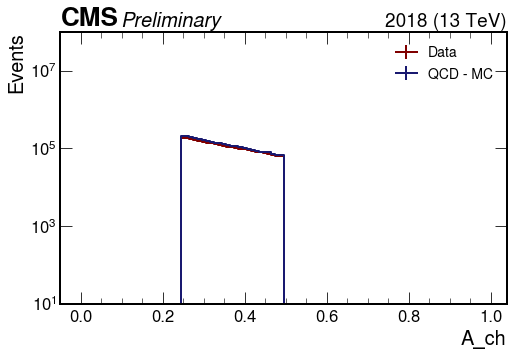

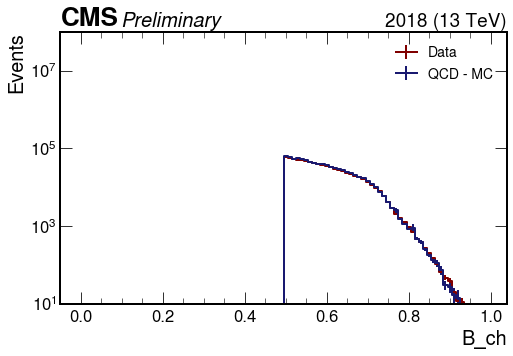

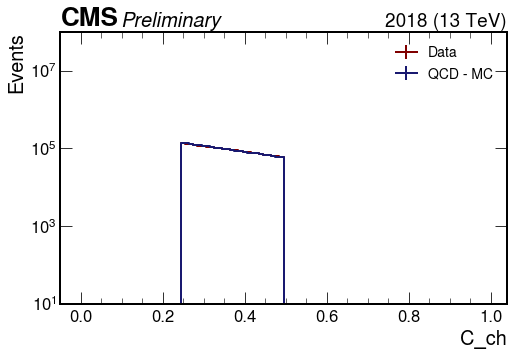

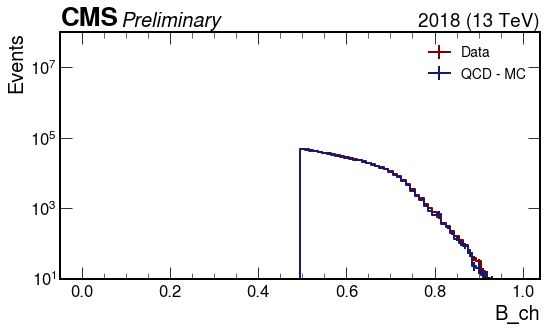

In [59]:
### Make ABCD plots and table based on selection (e.g. 'ch', 'mult')
selection = 'ch'
save = False
lumi = 61000

for plot_label in ['A_'+selection,'B_'+selection,'C_'+selection,'D_exp_'+selection,'D_obs_'+selection]:
        
    if 'D_obs' in plot_label and (not unblind): continue
    
    # define figure, axis on which to plot QCD and SUEP
    fig, ax = plt.subplots(figsize=(8,5))
    hep.cms.label("Preliminary", data=True, year=2018)

    # QCD hist for ABCD region
    hdata = plots['data'][plot_label]
    hQCD_MC = plots['QCD_MC'][plot_label] * lumi
    
    # plot QCD, sum values and errs
    plot1d(hdata, ax, 'Data', color='maroon', lw=2)
    plot1d(hQCD_MC, ax, 'QCD - MC', color='midnightblue', lw=2)
    
    data['data'][plot_label]["value"] = np.sum(hdata.values())
    data['data'][plot_label]["err"] = np.sum(np.sqrt(hdata.variances()))
    data['QCD_MC'][plot_label]["value"] = np.sum(hQCD_MC.values())
    data['QCD_MC'][plot_label]["err"] = np.sum(np.sqrt(hQCD_MC.variances()))
    
    ax.set_ylim(1e1,1e8)
    ax.set_yscale('log')
    ax.legend(loc='best', fontsize=14, framealpha=1, facecolor='white', shadow=True)
    
    if save: fig.savefig(output_label + "_" + plot_label + file_ext, bbox_inches='tight')

fig.tight_layout()
fig.show()

### DEBUG

## Closure Plots
Make closure plots for the 4 regions.<br>
Parameters:<br>
`selection`: _str_, which selection to use, e.g. 'ch', 'mult'.<br>
`save`: _bool_, whether to atuomatically save the plots.<br>
`lumi`: _float_, scales MC data.<br>

/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in

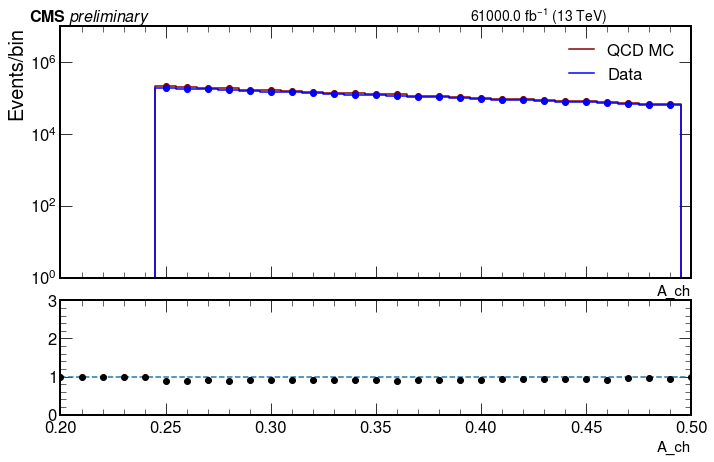

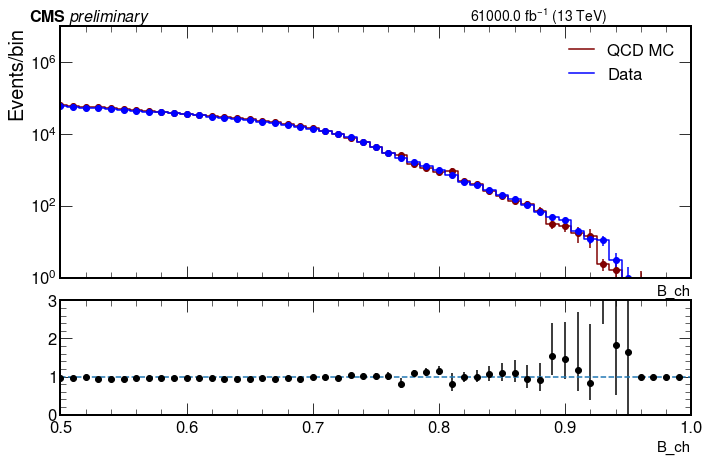

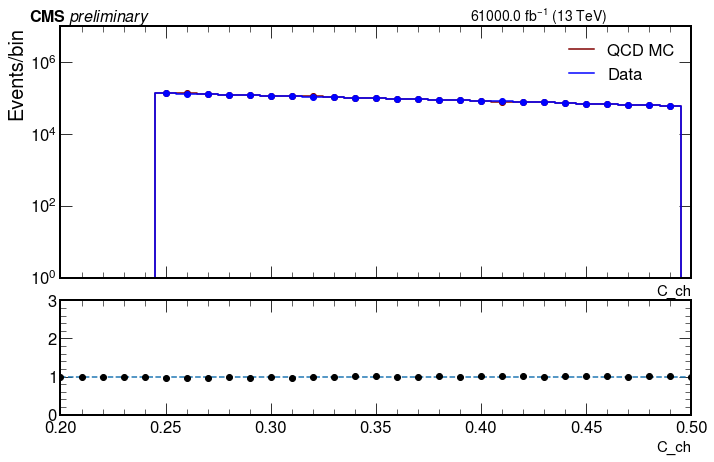

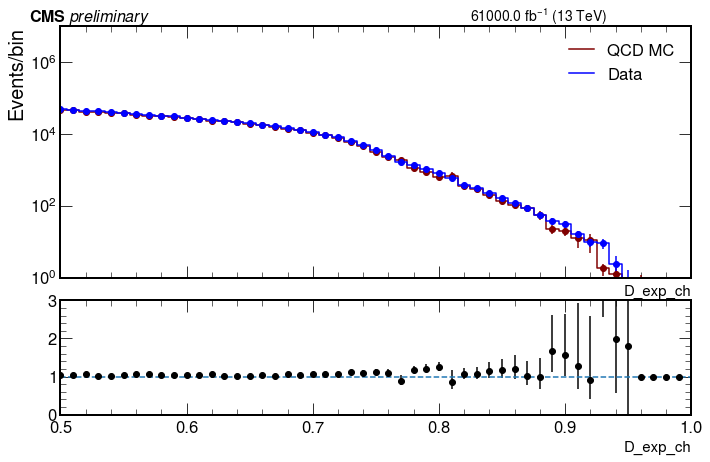

In [21]:
### Make ABCD plots and table based on selection (e.g. 'ch', 'mult')
selection = 'ch'
save = True
lumi = 61000

for plot_label in ['A_'+selection,'B_'+selection,'C_'+selection,'D_exp_'+selection,'D_obs_'+selection]:
    
    if 'D_obs' in plot_label and (not unblind): continue    
    
    hQCD_MC = plots['QCD_MC'][plot_label]
    hdata = plots['data'][plot_label]

    #Set up variables for the stacked histogram
    plt.figure(figsize=(12,10))
    plt.gcf().subplots_adjust(bottom=0.15, left=0.17)
    ax1 = plt.subplot2grid((4,1), (0,0),rowspan=2)

    QCD_MC, x = hQCD_MC.to_numpy()
    QCD_MC = QCD_MC*lumi
    hQCD_MC_errs = np.sqrt(hQCD_MC.variances())*lumi
    ax1.step(x[:-1],QCD_MC, color='maroon',label="QCD MC", where='mid')
    ax1.errorbar(x[:-1],QCD_MC, yerr=hQCD_MC_errs, color="maroon".upper(), fmt='o')

    data, x = hdata.to_numpy()
    hdata_errs = np.sqrt(hdata.variances())
    ax1.step(x[:-1],data, color='blue',label="Data", where= 'mid')
    ax1.errorbar(x[:-1],data, yerr=hdata_errs, color="blue".upper(), fmt='o')
    
    
    #Set parameters that will be used to make the plots prettier
    ax1.set_yscale("log")
    ymax = 1e7
    ax1.set_ylim([1e0, ymax])
    if 'A_' in plot_label or 'C_' in plot_label:
        xmin = 0.2
        xmax = 0.5
        ax1.set_xlim([xmin,xmax])
    elif 'B_' in plot_label or 'D_' in plot_label:
        xmin = 0.5
        xmax = 1.0
        ax1.set_xlim([xmin,xmax])
    #max_y = ax1.gca().get_ylim()[1]
    max_y = ymax + ymax*0.2
    max_x = xmax
    min_x = xmin
    x_range = max_x - min_x
    lower_label = min_x - x_range*0.05
    upper_label = max_x - x_range*0.35
    

    #X and Y labels (Do not use the central matplotlob default), text, and legend
    ax1.set_xlabel(plot_label, x=1, ha='right', fontsize=15)
    ax1.set_ylabel("Events/bin", y=1, ha='right')
    cms_txt = ax1.text(
            lower_label, max_y*1.08, u"CMS $\it{preliminary}$",
            fontsize=16, fontweight='bold',
    )

    lumi_txt = ax1.text(
            upper_label, max_y*1.08, r"%.1f fb$^{-1}$ (13 TeV)" % lumi,
            fontsize=14, 
    )
    ax1.legend()

    ax2 = plt.subplot2grid((4,1), (2,0),sharex=ax1)
    plt.setp(ax1.get_xticklabels(), visible=False)
    
    # calculate the upper and lower errors
    # suppress errors where the denonminator is 0
    QCD_MC = np.where(QCD_MC>0, QCD_MC, -1)
    yerrors_up = np.where(QCD_MC>0, data/QCD_MC - (data-hdata_errs)/(QCD_MC+hQCD_MC_errs), np.nan)
    yerrors_low = np.where(QCD_MC>0, (data+hdata_errs)/(QCD_MC-hQCD_MC_errs) - data/QCD_MC, np.nan)
    yerrors = [yerrors_up, yerrors_low]

    ax2.errorbar(x[:-1],np.where((data>0) & (QCD_MC>0),data/QCD_MC,1),yerr=yerrors, color="black", fmt='o')
    ax2.axhline(1, ls="--")
    ax2.set_ylim(0,3)
    ax2.set_xlabel(plot_label, fontsize=15)
    if save: plt.savefig(output_label + "_" + plot_label+ "_closure_"+selection+file_ext)

## Other Plots
Make more plots.<br>
Parameters:<br>
`selection`: _str_, which selection to use, e.g. 'ch', 'mult'.<br>
`save`: _bool_, whether to atuomatically save the plots.<br>
`lumi`: _float_, scales MC data.<br>
`plot_labels`: _list_, which plots you want to make.

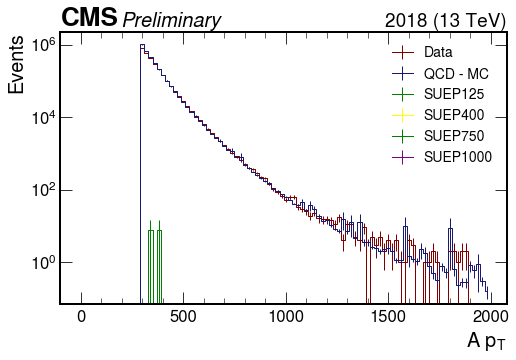

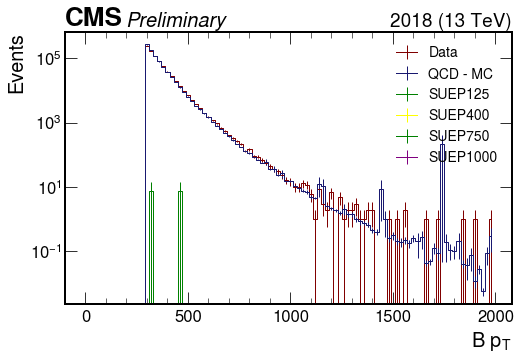

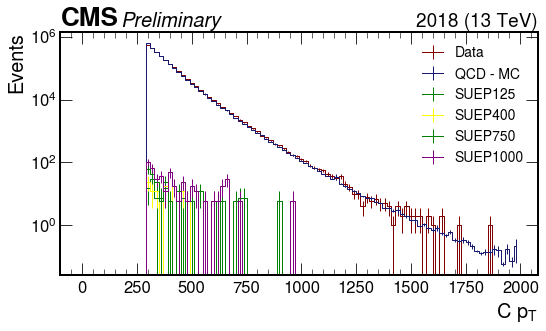

In [47]:
selection = 'ch'
save = True
lumi = 61000
plot_labels = ['A_pt', 'B_pt', 'C_pt']

for plot_label in plot_labels:
    
    #plot_label = 'SUEP_' + selection + '_' + plot_label
    plot_label = plot_label + '_' + selection
    
    # define figure, axis on which to plot QCD and SUEP
    fig, ax = plt.subplots(figsize=(8,5))
    hep.cms.label("Preliminary", data=True, year=2018)

    # get hists
    hdata = plots['data'][plot_label]
    hQCD_MC = plots['QCD_MC'][plot_label] * lumi
    hSUEP125 = plots['SUEP-m125-darkPho'][plot_label] * lumi
    hSUEP400 = plots['SUEP-m400-darkPho'][plot_label] * lumi
    hSUEP750 = plots['SUEP-m750-darkPho'][plot_label] * lumi
    hSUEP1000 = plots['SUEP-m1000-darkPho'][plot_label] * lumi
    
    # plot QCD, sum values and errs
    plot1d(hdata, ax, 'Data', color='maroon', lw=1)
    plot1d(hQCD_MC, ax, 'QCD - MC', color='midnightblue', lw=1)
    plot1d(hSUEP125, ax, 'SUEP125', color='green', lw=1)
    plot1d(hSUEP400, ax, 'SUEP400', color='yellow', lw=1)
    plot1d(hSUEP750, ax, 'SUEP750', color='green', lw=1)
    plot1d(hSUEP1000, ax, 'SUEP1000', color='purple', lw=1)
    
    #data['data'][plot_label]["value"] = np.sum(hdata.values())
    #data['data'][plot_label]["err"] = np.sum(np.sqrt(hdata.variances()))
    #data['QCD_MC'][plot_label]["value"] = np.sum(hQCD_MC.values())
    #data['QCD_MC'][plot_label]["err"] = np.sum(np.sqrt(hQCD_MC.variances()))
    
    # plotting parameters
    #ax.set_ylim(1e1,1e8)
    #ax.set_xlim(0,100)
    ax.set_yscale('log')
    ax.legend(loc='best', fontsize=14, framealpha=1, facecolor='white', shadow=True)
    
    if save: fig.savefig(output_label + "_" + plot_label + file_ext, bbox_inches='tight')
    
fig.tight_layout()
fig.show()

## Table

Make comparison table by running next 3 cells. The output is meant to be in Latex format.

In [9]:
table = []
for i in range(len(list(SUEPdata.keys()))):
    label = list(SUEPdata.keys())[i]
    line = []
    line.append(label)
    
    for r in ['A_'+selection,'B_'+selection,'C_'+selection,'D_exp_'+selection,'D_obs_'+selection]:
        if 'QCD' in label:
            line.append("{:0.0f} ".format(SUEPdata[label][r]['value']) + r'$\pm$' + " {:0.0f}".format(SUEPdata[label][r]['err']))
        else:
            line.append("{:0.2f} ".format(SUEPdata[label][r]['value']) + r'$\pm$' + " {:0.2f}".format(SUEPdata[label][r]['err']))
        
    if 'QCD' in label:
        line.append(round((SUEPdata[label]['D_exp_'+selection]['value']-SUEPdata[label]['D_obs_'+selection]['value'])/SUEPdata[label]['D_exp_'+selection]['value'],2))
        line.append(0)
    else:
        line.append(0)
        line.append(SUEPdata[label]['D_obs_'+selection]['value']/math.sqrt(SUEPdata[label]['D_obs_'+selection]['value']+SUEPdata[label]['D_exp_'+selection]['value']+SUEPdata[label]['D_obs_'+selection]['err']+SUEPdata['QCD']['D_exp_'+selection]['err']))
    table.append(line)                                                         

NameError: name 'SUEPdata' is not defined

In [ ]:
t = tabulate(table,tablefmt ='latex',
               headers=['Process', 'A', 'B', 'C', 'D_{exp}', 'D_{obs}', 'D_{exp}-D_{obs}/D_{exp}', 'S/$\sqrt(S+B+\sigma_{S}+\sigma_{B}$)'])
with open('table.txt', 'w') as f:
    f.write(t)
t

In [99]:
def convert2LatexString(s):
    r = r'(\^\{\})'; s = re.sub(r, "^", s)
    s = re.sub(r'\\([\$\_\{\}\^])', r'\1', s)
    s = re.sub(r'(\\textbackslash{})', r'\\', s)
    return s

t = convert2LatexString(t)
with open('table.txt', 'w') as f:
    f.write(t)
t

'\\begin{tabular}{llllllrr}\n\\hline\n Process            & A                  & B                 & C                 & D_{exp}           & D_{obs}           &   D_{exp}-D_{obs}/D_{exp} &   S/$\\sqrt(S+B+\\sigma_{S}+\\sigma_{B}$) \\\\\n\\hline\n SUEP-m1000-darkPho & 0.00 $\\pm$ 0.00    & 0.00 $\\pm$ 0.00   & 2.18 $\\pm$ 1.48   & 0.00 $\\pm$ 0.00   & 46.26 $\\pm$ 6.80  &                      0    &                              1.19059   \\\\\n SUEP-m750-darkPho  & 0.00 $\\pm$ 0.00    & 0.00 $\\pm$ 0.00   & 1.57 $\\pm$ 1.25   & 0.00 $\\pm$ 0.00   & 19.48 $\\pm$ 4.41  &                      0    &                              0.506162  \\\\\n SUEP-m400-darkPho  & 0.00 $\\pm$ 0.00    & 0.00 $\\pm$ 0.00   & 0.45 $\\pm$ 0.67   & 0.00 $\\pm$ 0.00   & 4.87 $\\pm$ 2.21   &                      0    &                              0.127279  \\\\\n SUEP-m125-darkPho  & 0.07 $\\pm$ 0.26    & 0.10 $\\pm$ 0.32   & 0.29 $\\pm$ 0.54   & 0.41 $\\pm$ 0.64   & 0.78 $\\pm$ 0.88   &                      0 